## 0. Imports and agnostic code

In [41]:
try:
    from ultralytics import YOLO
except:
    %pip install -q ultralytics

In [42]:
# import torch
# import numpy as np
import cv2 as cv
from pathlib import Path
import time
device = "cpu"
device

'cpu'

## 1. Object detection using YOLO11

In [43]:
model = YOLO("yolo11n.pt")
# model = YOLO("yolo11x-cls.pt")

# Test working of model
img_path = Path("pics/bus.jpg")
results = model(img_path)
results[0].show()


image 1/1 c:\Users\jayat\projects\object identification with cnn\pics\bus.jpg: 640x480 4 persons, 1 bus, 384.4ms
Speed: 45.6ms preprocess, 384.4ms inference, 46.1ms postprocess per image at shape (1, 3, 640, 480)


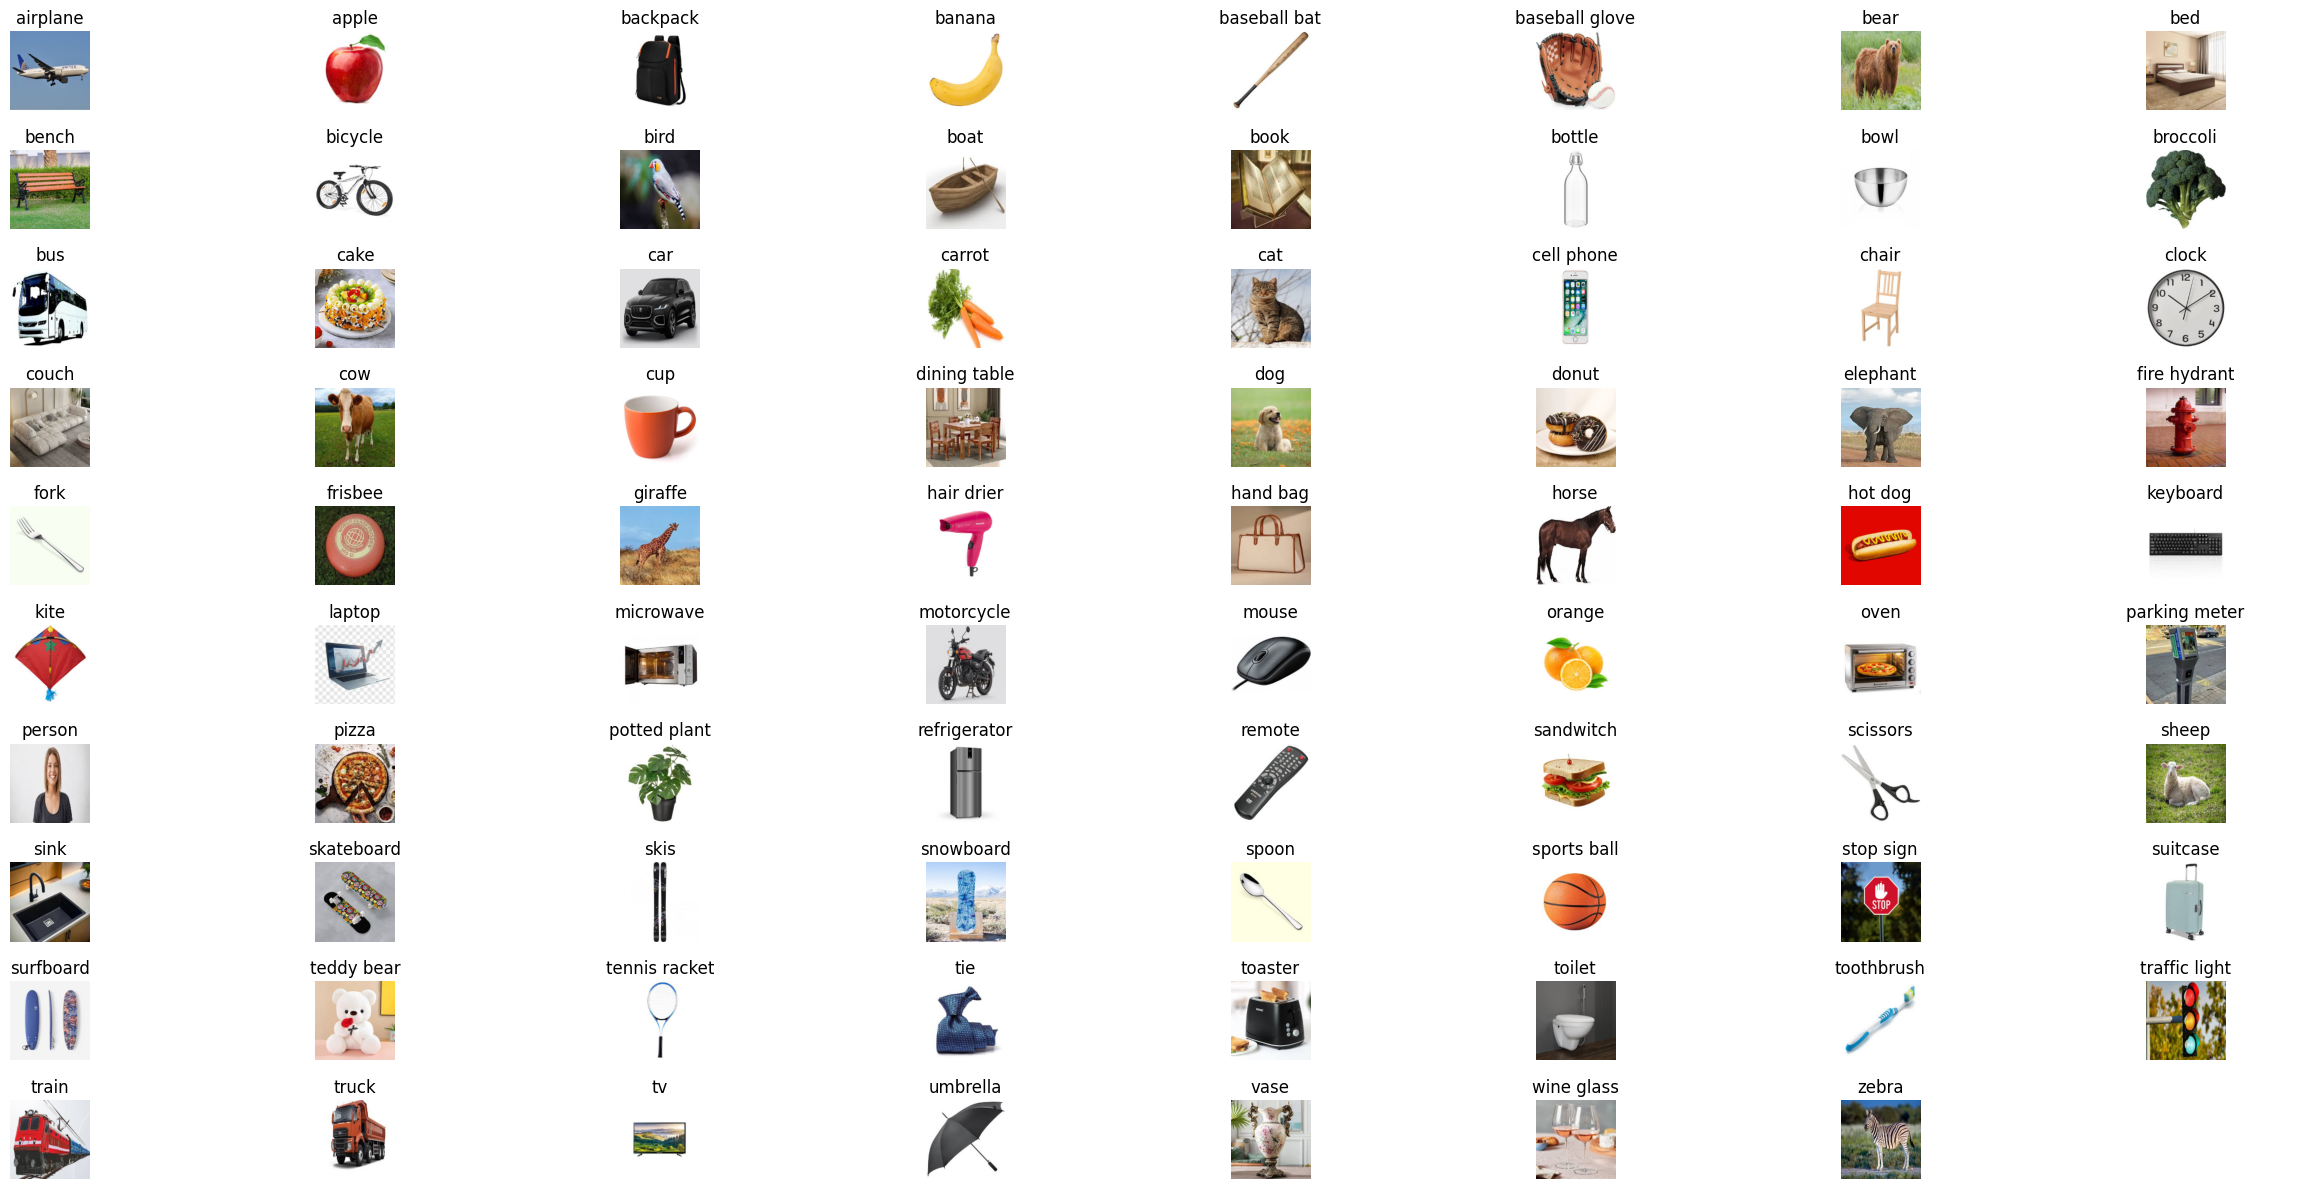

In [44]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Path to your folder containing the 80 class images
image_folder = Path("datasets") / "coco_classes"

# Get all images
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpeg')])

# Number of columns and rows
cols = 8
rows = 10

# Create a figure (increase width and height for bigger images)
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
axes = axes.flatten()  # Flatten to index easily

for i, ax in enumerate(axes):
    if i < len(image_files):
        img_path = os.path.join(image_folder, image_files[i])
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (150, 150))  # slightly bigger thumbnails

        ax.imshow(img)
        label = os.path.splitext(image_files[i])[0]
        ax.set_title(label, fontsize=12)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


## 2. Function to check stable objects

In [69]:

seen = dict()

def update_object_tracking(detected_labels, seen_objects, stable_objects, threshold=30):
    """
    Update seen_objects and stable_objects based on detected_labels.

    Args:
        detected_labels (list): list of class labels detected in current frame
        seen_objects (dict): {label: first_seen_time}
        stable_objects (set): set of labels confirmed after threshold seconds
        threshold (int): time in seconds before confirming object as stable

    Returns:
        tuple: (seen_objects, stable_objects, new_stable)
    """
    current_time = time.time()
    new_stable = set()

    # Track newly seen or persistent objects
    for label in detected_labels:
        
        # Save time with label
        if label not in seen_objects:
            seen_objects[label] = current_time
            seen[label] = current_time
        else:
            if (current_time - seen_objects[label] > threshold) and (label not in stable_objects):
                stable_objects.add(label)
                new_stable.add(label)

    # Reset objects that disappeared
    for label in list(seen_objects.keys()):
        if label not in detected_labels:
            seen_objects.pop(label, None)
            stable_objects.discard(label)

    return seen_objects, stable_objects, new_stable


## 3. TTS function

In [ ]:
import pyttsx3

def speak_objects(objects):
    """
    Convert a set of object labels into speech.
    Args:
        objects (set): set of labels (strings)
    """
    if not objects:
        return
    engine = pyttsx3.init()
    for obj in objects:
        engine.say(f"I see a {obj}")
        # obs.append(objects)
    engine.runAndWait()


## 4. Saving objects

In [47]:
import json
from datetime import datetime

def save_seen_objects(seen_objects, filename="seen_objects.json", as_json=True):
    """
    Save seen objects with timestamps to a file.

    Args:
        seen_objects (dict): {label: first_seen_time (epoch seconds)}
        filename (str): output file name
        as_json (bool): True to save as JSON, False to save as TXT
    """
    # Convert timestamps to readable format
    readable_data = {
        label: datetime.fromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S")
        for label, ts in seen_objects.items()
    }

    if as_json:
        with open(filename, "w") as f:
            json.dump(readable_data, f, indent=4)
        print(f"Saved seen objects to {filename} (JSON format).")
    else:
        with open(filename, "w") as f:
            for label, ts in readable_data.items():
                f.write(f"{label}: {ts}\n")
        print(f"Saved seen objects to {filename} (TXT format).")


## 5. Final loop

In [ ]:
def run_object_detection():
    """
    Combines the TTS and camera modules.
    """
    model = YOLO("yolo11n.pt")  # Load YOLO model

    seen_objects = {}
    stable_objects = set()

    # External camera source (for better quality video capture)
    cap = cv.VideoCapture(1)

    # If external camera not connected:
    if not cap.isOpened():
        print("Camera index 1 not found. Falling back to default camera.")
        cap.release()
        cap = cv.VideoCapture(0)

    # Final check
    if not cap.isOpened():
        print("Error: Could not open any camera.")
        exit()

    print("Camera initialized successfully!")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Run YOLO detection
        results = model(frame)
        boxes = results[0].boxes
        detected_labels = []

        # Pass frames through detection model
        if boxes is not None:
            for c in boxes.cls:
                label = model.names[int(c)]
                detected_labels.append(label)

        # Update trackers
        seen_objects, stable_objects, new_stable = update_object_tracking(
            detected_labels, seen_objects, stable_objects, threshold=2
        )

        # Speak newly stable objects
        if new_stable:
            speak_objects(new_stable)
            print(seen_objects)

        # Show annotated frame
        annotated_frame = results[0].plot()
        cv.imshow("YOLO Live Feed", annotated_frame)

        # Quit if 'q' is pressed
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

    print("Stable objects (seen for 30s):", seen_objects)
    save_seen_objects(seen, filename="seen_objects.json", as_json=True)


In [71]:
if __name__ == "__main__":
    run_object_detection()

Camera initialized successfully!

0: 480x640 1 person, 130.0ms
Speed: 3.4ms preprocess, 130.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 132.3ms
Speed: 3.2ms preprocess, 132.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 87.2ms
Speed: 1.6ms preprocess, 87.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 refrigerator, 119.7ms
Speed: 2.3ms preprocess, 119.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.8ms
Speed: 2.7ms preprocess, 123.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 123.8ms
Speed: 3.2ms preprocess, 123.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 102.5ms
Speed: 1.7ms preprocess, 102.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 130.6ms
Speed: 3.0ms preprocess, 13